In [1]:
import kagglehub
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
print("Path to dataset files:", path)
path = path + "/kagglecatsanddogs_3367a/PetImages"



Path to dataset files: /Users/aman/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1


In [3]:
files = os.listdir(path)

animal = []

for file in files:
    
    if file != ".DS_Store":
        animal.append(os.path.join(path, file))

print(animal)



['/Users/aman/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat', '/Users/aman/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog']


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

my_data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}





In [5]:
data_dir = 'hymenoptera_data'

# dog_dir = animal[1]

data_check = "/Users/aman/Stuff/Programming/CatVsDog/Cat_Dog"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}  

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}


my_image_datasets = {x: datasets.ImageFolder(os.path.join(data_check, x), my_data_transforms[x]) for x in ['Train', 'Validation']}

my_dataloaders = {x: torch.utils.data.DataLoader(my_image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['Train', 'Validation']}

print(my_image_datasets)
print("--------------------------------------")
print(my_dataloaders)

{'Train': Dataset ImageFolder
    Number of datapoints: 9940
    Root location: /Users/aman/Stuff/Programming/CatVsDog/Cat_Dog/Train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'Validation': Dataset ImageFolder
    Number of datapoints: 2486
    Root location: /Users/aman/Stuff/Programming/CatVsDog/Cat_Dog/Validation
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
--------------------------------------
{'Train': <torch.utils.data.dataloader.DataLoader object a

In [19]:
my_class_names = my_image_datasets['Train'].classes # Gives a list of the different type of images

print(my_class_names)

['Cats', 'Dogs']


In [7]:
if torch.accelerator.is_available():
    current_device = torch.accelerator.current_accelerator()
else:
    current_device = torch.device("cpu")
if current_device.type == 'cuda':
    is_half_supported = torch.cuda.has_half
elif current_device.type == 'xpu':
    is_half_supported = torch.xpu.get_device_properties().has_fp16
elif current_device.type == 'cpu':
    is_half_supported = True

In [8]:
print(torch.__version__)
print()

2.6.0



In [11]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(device)

mps


In [16]:
inputs, classes = next(iter(dataloaders['train']))
my_inputs, my_classes = next(iter(my_dataloaders["Train"]))



In [37]:
out = torchvision.utils.make_grid(my_inputs, padding = 10)

print(type(out))

print(type(my_class_names))


<class 'torch.Tensor'>
<class 'list'>


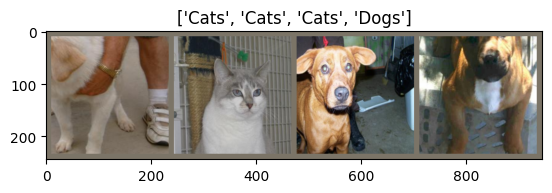

2


In [40]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

imshow(out, title = [my_class_names[x] for x in classes]) # out is a tensor and my_class_names is a list

print(len(my_class_names))

In [50]:
def train_model(model, criterion, optimizer, schedular, num_epochs = 25):
    since = time.time()
    print(since)
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0


model_ft = models.resnet18(weights='IMAGENET1K_V1')

print(model_ft)




# train_model(0,0,0,0,0)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/aman/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 16.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
!echo "# CatVsDog_Pytorch" >> README.md
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/amannindra/CatVsDog_Pytorch.git
!git push -u origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint:
hint: 	git config --global init.defaultBranch <name>
hint:
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint:
hint: 	git branch -m <name>
Initialized empty Git repository in /Users/aman/Stuff/Programming/CatVsDog/.git/
[master (root-commit) 992f884] first commit
 1 file changed, 1 insertion(+)
 create mode 100644 README.md
Enumerating objects: 3, done.
Counting objects: 100% (3/3), done.
Writing objects: 100% (3/3), 233 bytes | 233.00 KiB/s, done.
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
To https://github.com/amannindra/CatVsDog_Pytorch.git
 * [new branch]      main -> main
branch 'main' set up to track 'origin/main'.
